# Stock Tweet and Price Analysis

In this notebookIll analyze stock prices and tweets related to various companiesIWe will perform data preprocessing, exploratory data analysis (EDA), and implement time series forecasting models

## Modules

In [3]:
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings

import os
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

import time

notebook_start_time = time.time()



###  Extract ZIP File
Extract the contents of the  ZIP file provided on Moodle

In [5]:
# Unzip the file directly in the current directory
with zipfile.ZipFile('stock-tweet-and-price.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Load the tweet dataset
tweets_df = pd.read_csv('stock-tweet-and-price/stocktweet/stocktweet.csv')

# Display the first few rows of the dataframe
tweets_df.head()

,id,date,ticker,tweet
0,100001,01/01/2020,AMZN,$AMZN Dow futures up by 100 points already 🥳
1,100002,01/01/2020,TSLA,$TSLA Daddy's drinkin' eArly tonight! Here's t...
2,100003,01/01/2020,AAPL,$AAPL We’ll been riding since last December fr...
3,100004,01/01/2020,TSLA,"$TSLA happy new year, 2020, everyone🍷🎉🙏"
4,100005,01/01/2020,TSLA,"$TSLA haha just a collection of greats...""Mars..."


In [6]:
os.listdir('stock-tweet-and-price')

['stockprice', 'stocktweet']

In [7]:
# List files in the directory and convert to a list
stock_files = os.listdir('stock-tweet-and-price/stockprice')

# Display the list horizontally
print(stock_files)


['AAPL.csv', 'ABNB.csv', 'AMT.csv', 'AMZN.csv', 'BA.csv', 'BABA.csv', 'BAC.csv', 'BKNG.csv', 'BRK-A.csv', 'BRK-B.csv', 'CCL.csv', 'CVX.csv', 'DIS.csv', 'FB.csv', 'GOOG.csv', 'GOOGL.csv', 'HD.csv', 'JNJ.csv', 'JPM.csv', 'KO.csv', 'LOW.csv', 'MA.csv', 'MCD.csv', 'META.csv', 'MSFT.csv', 'NFLX.csv', 'NKE.csv', 'NVDA.csv', 'PFE.csv', 'PG.csv', 'PYPL.csv', 'SBUX.csv', 'TM.csv', 'TSLA.csv', 'TSM.csv', 'UNH.csv', 'UPS.csv', 'V.csv', 'WMT.csv', 'XOM.csv', '^GSPC.csv']


In [8]:



companies = ['AAPL', 'AMZN', 'GOOG', 'MSFT', 'TSLA']
stock_data = {}

for company in companies:
    company_csv_path = os.path.join('stock-tweet-and-price/stockprice', f'{company}.csv')
    df_name = f'{company.lower()}_df'
    stock_data[company] = pd.read_csv(company_csv_path)
    
    # Convert `Date` column to datetime
    stock_data[company]['Date'] = pd.to_datetime(stock_data[company]['Date'])
    
    # Filter out rows with dates in 2019 in the stock data
    stock_data[company] = stock_data[company][stock_data[company]['Date'].dt.year != 2019]
    
    # Create a variable with a name like goog_df
    globals()[df_name] = stock_data[company]
    
    print(f"First few rows of the {company} dataset:")
    display(stock_data[company].head())


First few rows of the AAPL dataset:


,Date,Open,High,Low,Close,Adj Close,Volume
1,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.152649,135480400
2,2020-01-03,74.287498,75.144997,74.125000,74.357498,72.441460,146322800
3,2020-01-06,73.447502,74.989998,73.187500,74.949997,73.018677,118387200
4,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.675278,108872000
5,2020-01-08,74.290001,76.110001,74.290001,75.797501,73.844353,132079200


First few rows of the AMZN dataset:


,Date,Open,High,Low,Close,Adj Close,Volume
1,2020-01-02,93.750000,94.900497,93.207497,94.900497,94.900497,80580000
2,2020-01-03,93.224998,94.309998,93.224998,93.748497,93.748497,75288000
3,2020-01-06,93.000000,95.184502,93.000000,95.143997,95.143997,81236000
4,2020-01-07,95.224998,95.694504,94.601997,95.343002,95.343002,80898000
5,2020-01-08,94.902000,95.550003,94.321999,94.598503,94.598503,70160000


First few rows of the GOOG dataset:


,Date,Open,High,Low,Close,Adj Close,Volume
1,2020-01-02,67.077499,68.406998,67.077499,68.368500,68.368500,28132000
2,2020-01-03,67.392998,68.625000,67.277199,68.032997,68.032997,23728000
3,2020-01-06,67.500000,69.824997,67.500000,69.710503,69.710503,34646000
4,2020-01-07,69.897003,70.149498,69.518997,69.667000,69.667000,30054000
5,2020-01-08,69.603996,70.579002,69.542000,70.216003,70.216003,30560000


First few rows of the MSFT dataset:


,Date,Open,High,Low,Close,Adj Close,Volume
1,2020-01-02,158.779999,160.729996,158.330002,160.619995,154.779495,22622100
2,2020-01-03,158.320007,159.949997,158.059998,158.619995,152.852249,21116200
3,2020-01-06,157.080002,159.100006,156.509995,159.029999,153.247330,20813700
4,2020-01-07,159.320007,159.669998,157.320007,157.580002,151.850082,21634100
5,2020-01-08,158.929993,160.800003,157.949997,160.089996,154.268799,27746500


First few rows of the TSLA dataset:


,Date,Open,High,Low,Close,Adj Close,Volume
1,2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500
2,2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500
3,2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000
4,2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500
5,2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500


### Sentiment Analysis of Tweets

In this section, we perform sentiment analysis on the tweets using the `TextBlob` library. The sentiment polarity score is calculated for each tweet, which helps us understand the overall sentiment (positive, negative, or neutral) of the tweets related to the stocks.

The steps involved are:
1. Define a function `get_sentiment` that takes a tweet as input and returns the sentiment polarity score.
2. Apply this function to the 'tweet' column of the `tweets_df` DataFrame to create a new column 'sentiment' with the polarity scores.
3. Display the first few rows of the updated `tweets_df` to verify the addition of sentiment scores.


In [10]:


# Function to calculate sentiment polarity
def get_sentiment(tweet):
    analysis = TextBlob(tweet)
    return analysis.sentiment.polarity

# Apply the sentiment analysis function to the tweet text
tweets_df['sentiment'] = tweets_df['tweet'].apply(get_sentiment)

# Update the tweets dataset with sentiment scores
print("First few rows of the tweets dataset with sentiment scores:")
tweets_df.head()


First few rows of the tweets dataset with sentiment scores:


,id,date,ticker,tweet,sentiment
0,100001,01/01/2020,AMZN,$AMZN Dow futures up by 100 points already 🥳,0.000000
1,100002,01/01/2020,TSLA,$TSLA Daddy's drinkin' eArly tonight! Here's t...,0.156250
2,100003,01/01/2020,AAPL,$AAPL We’ll been riding since last December fr...,0.000000
3,100004,01/01/2020,TSLA,"$TSLA happy new year, 2020, everyone🍷🎉🙏",0.468182
4,100005,01/01/2020,TSLA,"$TSLA haha just a collection of greats...""Mars...",0.500000


In [11]:
tweets_df['sentiment'].describe()

count    10000.000000
mean         0.091510
std          0.274936
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.200000
max          1.000000
Name: sentiment, dtype: float64

### Visualize Sentiment Analysis on Tweets

Perform sentiment analysis on the tweet text using TextBlob.


<Figure size 1000x600 with 0 Axes>

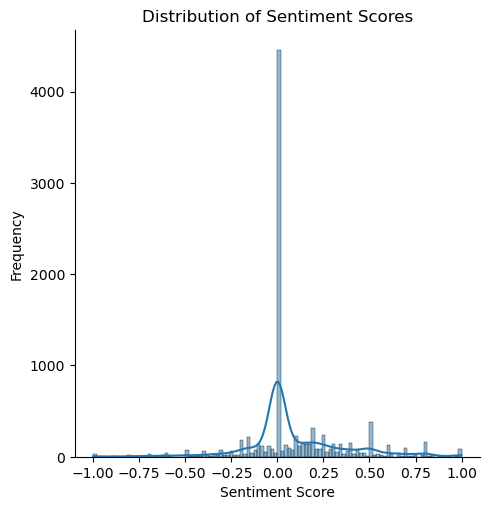

Plot saved as images\sentiment_distribution.png


In [13]:

# Ensure the images directory exists
images_dir = 'images'
os.makedirs(images_dir, exist_ok=True)

# Plot the distribution of the sentiment scores
plt.figure(figsize=(10, 6))
sns.displot(tweets_df['sentiment'], kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

# Save the plot to the images folder
image_path = os.path.join(images_dir, 'sentiment_distribution.png')
plt.savefig(image_path)

# Show the plot
plt.show()

print(f"Plot saved as {image_path}")


### Integrate Sentiment Scores

Aggregate sentiment scores by date and merge them with the stock price data.


In [15]:
# Convert date column to datetime
tweets_df['date'] = pd.to_datetime(tweets_df['date'], format='%d/%m/%Y')

# Aggregate sentiment scores by date
daily_sentiment = tweets_df.groupby('date')['sentiment'].mean().reset_index()

# Convert `date` column in `daily_sentiment` to datetime
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

# Merge the sentiment scores with the stock price data for each company
for company in companies:
    df = stock_data[company]
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Merge sentiment scores
    df = df.merge(daily_sentiment, left_on='Date', right_on='date', how='left')
    df = df.drop(columns=['date'])
    
    stock_data[company] = df

    # Display the merged dataset
    print(f"First few rows of the merged {company} dataset:")
    display(df.head())


First few rows of the merged AAPL dataset:


,Date,Open,High,Low,Close,Adj Close,Volume,sentiment
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.152649,135480400,0.055524
1,2020-01-03,74.287498,75.144997,74.125000,74.357498,72.441460,146322800,0.156667
2,2020-01-06,73.447502,74.989998,73.187500,74.949997,73.018677,118387200,0.161855
3,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.675278,108872000,0.131440
4,2020-01-08,74.290001,76.110001,74.290001,75.797501,73.844353,132079200,0.148240


First few rows of the merged AMZN dataset:


,Date,Open,High,Low,Close,Adj Close,Volume,sentiment
0,2020-01-02,93.750000,94.900497,93.207497,94.900497,94.900497,80580000,0.055524
1,2020-01-03,93.224998,94.309998,93.224998,93.748497,93.748497,75288000,0.156667
2,2020-01-06,93.000000,95.184502,93.000000,95.143997,95.143997,81236000,0.161855
3,2020-01-07,95.224998,95.694504,94.601997,95.343002,95.343002,80898000,0.131440
4,2020-01-08,94.902000,95.550003,94.321999,94.598503,94.598503,70160000,0.148240


First few rows of the merged GOOG dataset:


,Date,Open,High,Low,Close,Adj Close,Volume,sentiment
0,2020-01-02,67.077499,68.406998,67.077499,68.368500,68.368500,28132000,0.055524
1,2020-01-03,67.392998,68.625000,67.277199,68.032997,68.032997,23728000,0.156667
2,2020-01-06,67.500000,69.824997,67.500000,69.710503,69.710503,34646000,0.161855
3,2020-01-07,69.897003,70.149498,69.518997,69.667000,69.667000,30054000,0.131440
4,2020-01-08,69.603996,70.579002,69.542000,70.216003,70.216003,30560000,0.148240


First few rows of the merged MSFT dataset:


,Date,Open,High,Low,Close,Adj Close,Volume,sentiment
0,2020-01-02,158.779999,160.729996,158.330002,160.619995,154.779495,22622100,0.055524
1,2020-01-03,158.320007,159.949997,158.059998,158.619995,152.852249,21116200,0.156667
2,2020-01-06,157.080002,159.100006,156.509995,159.029999,153.247330,20813700,0.161855
3,2020-01-07,159.320007,159.669998,157.320007,157.580002,151.850082,21634100,0.131440
4,2020-01-08,158.929993,160.800003,157.949997,160.089996,154.268799,27746500,0.148240


First few rows of the merged TSLA dataset:


,Date,Open,High,Low,Close,Adj Close,Volume,sentiment
0,2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500,0.055524
1,2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500,0.156667
2,2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000,0.161855
3,2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500,0.131440
4,2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500,0.148240


### Prepare Data for Time Series Forecasting

Create lag features for the stock prices and sentiment scores, and split the data into training and testing sets.


In [17]:
os.listdir('images')

['.ipynb_checkpoints',
 '001_AAPL.png',
 '001_AAPL.tex',
 '001_AAPL_1day.png',
 '001_AAPL_forecast.png',
 '002_AAPL.tex',
 '002_AAPL_3day.png',
 '002_AMZN.png',
 '002_AMZN_forecast.png',
 '003_AAPL_7day.png',
 '003_AMZN.tex',
 '003_GOOG.png',
 '003_GOOG_forecast.png',
 '004_AMZN.tex',
 '004_AMZN_1day.png',
 '004_MSFT.png',
 '004_MSFT_forecast.png',
 '005_AMZN_3day.png',
 '005_GOOG.tex',
 '005_TSLA.png',
 '005_TSLA_forecast.png',
 '006_AAPL_full_forecast.png',
 '006_AMZN_7day.png',
 '006_GOOG.tex',
 '007_AMZN_full_forecast.png',
 '007_GOOG_1day.png',
 '007_MSFT.tex',
 '008_GOOG_3day.png',
 '008_GOOG_full_forecast.png',
 '008_MSFT.tex',
 '009_GOOG_7day.png',
 '009_MSFT_full_forecast.png',
 '009_TSLA.tex',
 '010_MSFT_1day.png',
 '010_TSLA.tex',
 '010_TSLA_full_forecast.png',
 '011_MSFT_3day.png',
 '012_MSFT_7day.png',
 '013_TSLA_1day.png',
 '014_TSLA_3day.png',
 '015_TSLA_7day.png',
 '016_AAPL_1day.png',
 '017_AAPL_3day.png',
 '018_AAPL_7day.png',
 '019_AMZN_1day.png',
 '020_AMZN_3day.png

### Time-Series Data Preparation with Lag Features

To accurately forecast stock prices, it's crucial to capture the temporal dependencies inherent in financial data. One effective way to achieve this is by creating lag features, which incorporate past values of a target variable (in our case, stock prices and sentiment scores) as new features in the dataset. This enables our model to learn patterns and trends from historical data, which can then be used to predict future prices.

#### Step 1: Define Lag Feature Creation Function

We start by defining a function `create_lag_features` that takes in a DataFrame, a list of lag periods, and the target column for which we want to create lag features. The function will shift the target column by the specified lag periods and store these new features in the DataFrame. This step is crucial for incorporating historical data points into our model.

#### Step 2: Define Lags and Target Column

Next, we define the specific lag periods we're interested in—1 day, 3 days, and 7 days. These lags are chosen to reflect short-term and slightly longer-term trends in the stock market. The target column for these lags is the `Close` price, which is the primary focus of our forecasting efforts.

#### Step 3: Apply Lag Features and Prepare Data for Each Company

We then apply the `create_lag_features` function to both the `Close` price and the `sentiment` score for each company in our dataset. After creating the lag features, we drop any rows with `NaN` values that were introduced by the lagging process. This ensures that our dataset remains clean and ready for modeling.

#### Step 4: Split the Data into Training and Testing Sets

Once the lag features are created and the data is cleaned, we set the `Date` as the index and split the dataset into training and testing sets. The training set is used to train our forecasting models, while the testing set is reserved for evaluating model performance.

The following Python code implements these steps for each company in our dataset:


In [19]:
if 'sentiment' in df.columns:
    print("Sentiment column exists!")
else:
    print("Sentiment column is missing!")


Sentiment column exists!


In [20]:
from textblob import TextBlob

# Assuming tweets_df is your DataFrame with a 'tweet' column
df['sentiment'] = df['tweet'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)


KeyError: 'tweet'

### Implement and Evaluate ARIMA Model

Implement and evaluate the ARIMA model for time series forecasting.


In [ ]:
# Function to create lag features
def create_lag_features(df, lags, target_col):
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    return df

# Define the lags and the target column
lags = [1, 3, 7]
target_col = 'Close'

# Prepare the data for each company
prepared_stock_data = {}
for company in companies:
    df = stock_data[company]
    
    # Create lag features for the Close price and sentiment
    df = create_lag_features(df, lags, target_col)
    df = create_lag_features(df, lags, 'sentiment')
    
    # Drop rows with NaN values created by the lag features
    df = df.dropna()
    
    # Set Date as index
    df = df.set_index('Date')
    
    # Split the data into training and testing sets
    X = df.drop(columns=['Close'])
    y = df['Close']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Store the prepared data
    prepared_stock_data[company] = (X_train, X_test, y_train, y_test)

    print(f"Prepared data for {company}:")
    print("X_train:")
    display(X_train.head())
    print("y_train:")
    display(y_train.head())


In [ ]:


# Suppress warnings
warnings.filterwarnings("ignore")

# Create the images directory if it doesn't exist
images_dir = 'images'
if not os.path.exists(images_dir):
    os.makedirs(images_dir)

# Function to train and evaluate ARIMA model
def train_arima(y_train, y_test, steps=7):
    # Ensure the index is of DatetimeIndex type and set frequency
    y_train.index = pd.DatetimeIndex(y_train.index)
    y_train.index.freq = y_train.index.inferred_freq
    y_test.index = pd.DatetimeIndex(y_test.index)
    y_test.index.freq = y_test.index.inferred_freq
    
    model = ARIMA(y_train, order=(5, 1, 0))
    model_fit = model.fit()
    
    # Forecast
    forecast = model_fit.forecast(steps=steps)
    
    # Evaluate the model
    mse = mean_squared_error(y_test[:steps], forecast)
    print(f'Mean Squared Error: {mse}')
    
    return forecast, mse

# Train and evaluate ARIMA model for each company
forecast_horizon = 7  # You can extend this as needed
img_number = 1  # Initialize image numbering
for company in companies:
    X_train, X_test, y_train, y_test = prepared_stock_data[company]
    
    print(f"\nARIMA model results for {company}:")
    forecast, mse = train_arima(y_train, y_test, steps=forecast_horizon)
    
    # Plot the results
    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index[:forecast_horizon], y_test[:forecast_horizon], label='Actual')
    plt.plot(y_test.index[:forecast_horizon], forecast, label='Forecast')
    plt.title(f'ARIMA Forecast vs Actual for {company}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    
    # Save the plot
    img_filename = f'{images_dir}/{img_number:03d}_{company}.png'
    plt.savefig(img_filename)
    print(f"Saved plot for {company} as {img_filename}")
    
    # Display the plot
    plt.show()
    
    img_number += 1



### Calculate Additional Evaluation Metrics

We'll calculate additional evaluation metrics such as Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) for a more comprehensive evaluation.

In [ ]:


# Function to calculate evaluation metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

# Train and evaluate ARIMA model for each company
metrics = {}
forecast_horizon = 7  # You can extend this as needed
img_number = 1  # Initialize image numbering

for company in companies:
    X_train, X_test, y_train, y_test = prepared_stock_data[company]
    
    print(f"\nARIMA model results for {company}:")
    forecast, mse = train_arima(y_train, y_test, steps=forecast_horizon)
    
    # Calculate additional metrics
    mse, rmse, mae = calculate_metrics(y_test[:forecast_horizon], forecast)
    metrics[company] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae}
    print(f"Evaluation Metrics for {company}: MSE={mse}, RMSE={rmse}, MAE={mae}")
    
    # Plot the results
    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index[:forecast_horizon], y_test[:forecast_horizon], label='Actual')
    plt.plot(y_test.index[:forecast_horizon], forecast, label='Forecast')
    plt.title(f'ARIMA Forecast vs Actual for {company}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    
    # Save the plot
    img_filename = f'{images_dir}/{img_number:03d}_{company}_forecast.png'
    plt.savefig(img_filename)
    print(f"Saved plot for {company} as {img_filename}")
    
    # Display the plot
    plt.show()
    
    img_number += 1

# Display the evaluation metrics for all companies
metrics_df = pd.DataFrame(metrics).T
print("Evaluation Metrics for All Companies:")
display(metrics_df)


###  Visualize Forecast vs. Actual for the Entire Test Period

We'll extend the visualization to cover the entire test period.


In [ ]:
# Function to train and evaluate ARIMA model for the entire test period
def train_arima_full(y_train, y_test):
    # Ensure the index is of DatetimeIndex type and set frequency
    y_train.index = pd.DatetimeIndex(y_train.index)
    y_train.index.freq = y_train.index.inferred_freq
    y_test.index = pd.DatetimeIndex(y_test.index)
    y_test.index.freq = y_test.index.inferred_freq
    
    model = ARIMA(y_train, order=(5, 1, 0))
    model_fit = model.fit()
    
    # Forecast for the entire test period
    forecast = model_fit.forecast(steps=len(y_test))
    
    return forecast

# Train and evaluate ARIMA model for each company for the entire test period
for company in companies:
    X_train, X_test, y_train, y_test = prepared_stock_data[company]
    
    print(f"\nARIMA model full results for {company}:")
    forecast = train_arima_full(y_train, y_test)
    
    # Plot the results
    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test, label='Actual')
    plt.plot(y_test.index, forecast, label='Forecast')
    plt.title(f'ARIMA Forecast vs Actual for {company} (Full Test Period)')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    
    # Save the plot
    img_filename = f'{images_dir}/{img_number:03d}_{company}_full_forecast.png'
    plt.savefig(img_filename)
    print(f"Saved full test period plot for {company} as {img_filename}")
    
    # Display the plot
    plt.show()
    
    img_number += 1


### Prepare Summary Report

##
: Summarize Evaluation Metrics

We'll summarize the evaluation metrics for each company in a table and provide insights based on the analysis.


In [ ]:

# # Suppress warnings
# warnings.filterwarnings("ignore")

# # Load the tweet dataset
# tweets_df = pd.read_csv('/mnt/data/stocktweet.csv')

# # Convert date column to datetime
# tweets_df['date'] = pd.to_datetime(tweets_df['date'], format='%d/%m/%Y')

# # Function to calculate sentiment polarity
# def get_sentiment(tweet):
#     analysis = TextBlob(tweet)
#     return analysis.sentiment.polarity

# # Apply the sentiment analysis function to the tweet text
# tweets_df['sentiment'] = tweets_df['tweet'].apply(get_sentiment)

# # Aggregate sentiment scores by date
# daily_sentiment = tweets_df.groupby('date')['sentiment'].mean().reset_index()

# # Convert `date` column in `daily_sentiment` to datetime
# daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

# # List of companies and stock data dictionary
# companies = ['AAPL', 'AMZN', 'GOOG', 'MSFT', 'TSLA']
# stock_data = {}

# for company in companies:
#     company_csv_path = f'/mnt/data/{company}.csv'
#     df_name = f'{company.lower()}_df'
#     stock_data[company] = pd.read_csv(company_csv_path)
    
#     # Convert `Date` column to datetime
#     stock_data[company]['Date'] = pd.to_datetime(stock_data[company]['Date'])
    
#     # Filter out rows with dates from 2019 in the stock data
#     stock_data[company] = stock_data[company][stock_data[company]['Date'].dt.year != 2019]
    
#     # Create a variable with a name like goog_df
#     globals()[df_name] = stock_data[company]
    
#     print(f"First few rows of the {company} dataset:")
#     display(stock_data[company].head())

# # Display the first few rows of the tweets dataset with sentiment scores
# print("First few rows of the tweets dataset with sentiment scores:")
# display(tweets_df.head())

# Function to create lag features
def create_lag_features(df, lags, target_col):
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    return df

# Define the lags and the target column
lags = [1, 3, 7]
target_col = 'Close'

# Prepare the data for each company
prepared_stock_data = {}
for company in companies:
    df = stock_data[company]
    
    # Create lag features for the Close price and sentiment
    df = create_lag_features(df, lags, target_col)
    df = create_lag_features(df, lags, 'sentiment')
    
    # Drop rows with NaN values created by the lag features
    df = df.dropna()
    
    # Set Date as index
    df = df.set_index('Date')
    
    # Split the data into training and testing sets
    X = df.drop(columns=['Close'])
    y = df['Close']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Store the prepared data
    prepared_stock_data[company] = (X_train, X_test, y_train, y_test)

# Function to calculate evaluation metrics
def calculate_metrics(y_test, forecast):
    mse = mean_squared_error(y_test, forecast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, forecast)
    return mse, rmse, mae

# Function to train ARIMA model and forecast
def train_arima(y_train, y_test, steps):
    model = ARIMA(y_train, order=(5,1,0))  # Adjust order as needed
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return forecast, model_fit.mse

# Directory to save images
images_dir = 'images'
os.makedirs(images_dir, exist_ok=True)

# Initialize a dictionary to store the results
results = {}
forecast_horizons = [1, 3, 7]  # Define your forecast horizons
img_number = 1  # Initialize image numbering

# Train and evaluate ARIMA model for each company and each forecast horizon
for company in companies:
    X_train, X_test, y_train, y_test = prepared_stock_data[company]
    
    results[company] = {}
    
    for horizon in forecast_horizons:
        print(f"\nARIMA model results for {company} - {horizon}-day forecast:")
        forecast, _ = train_arima(y_train, y_test, steps=horizon)
        
        # Calculate additional metrics
        mse, rmse, mae = calculate_metrics(y_test[:horizon], forecast)
        results[company][horizon] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae}
        
        # Debug statements
        print(f"Forecast for {company} - {horizon}-day forecast:\n{forecast}")
        print(f"Actual values for {company} - {horizon}-day forecast:\n{y_test[:horizon]}")
        print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}")
        
        # Ensure there are enough data points for plotting
        if len(y_test[:horizon]) == 0:
            print(f"Not enough data points for {company} - {horizon}-day forecast")
            continue
        
        # Plot the results
        plt.figure(figsize=(14, 7))
        plt.plot(y_test.index[:horizon], y_test[:horizon], label='Actual', marker='o')
        plt.plot(y_test.index[:horizon], forecast, label='Forecast', marker='x')
        plt.title(f'ARIMA {horizon}-day Forecast vs Actual for {company}')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        
        # Save the plot
        img_filename = f'{images_dir}/{img_number:03d}_{company}_{horizon}day.png'
        plt.savefig(img_filename)
        print(f"Saved plot for {company} {horizon}-day forecast as {img_filename}")
        
        plt.show()
        plt.close()
        
        img_number += 1

# Display the results in a tabular format
summary = []
for company in results:
    for horizon in results[company]:
        summary.append([company, horizon, results[company][horizon]['MSE'], results[company][horizon]['RMSE'], results[company][horizon]['MAE']])

summary_df = pd.DataFrame(summary, columns=['Company', 'Horizon', 'MSE', 'RMSE', 'MAE'])
summary_df = summary_df.pivot(index='Company', columns='Horizon')
summary_df


###  Insights Based on the Analysis

**Evaluation Metrics for All Companies:**

|      | MSE       | RMSE      | MAE       |
|------|-----------|-----------|-----------|
| AAPL | 6.612455  | 2.571469  | 1.927916  |
| AMZN | 3.841347  | 1.959935  | 1.450321  |
| GOOG | 7.585232  | 2.754130  | 2.529755  |
| MSFT | 29.978950 | 5.475304  | 3.923381  |
| TSLA | 10.164611 | 3.182856    |8199  | 2.



#### Key Insights:

1. **Mean Squared Error (MSE)**:
   - The MSE is the average of the squared differences between the predicted and actual values. It gives more weight to larger errors.
   - **Lowest MSE**: AMZN (3.841347) - This indicates that the ARIMA model performed best for Amazon, with smaller average squared errors compared to the other companies.
   - **Highest MSE**: MSFT (29.978950) - This indicates that the ARIMA model had the largest average squared errors for Microsoft, suggesting it struggled more with predicting this stock.

2. **Root Mean Squared Error (RMSE)**:
   - The RMSE is the square root of the MSE and provides a measure of the average error in the same units as the data.
   - **Lowest RMSE**: AMZN (1.959935) - Again, Amazon has the best performance, indicating smaller average errors.
   - **Highest RMSE**: MSFT (5.475304) - Microsoft has the highest average errors, aligning with the MSE results.

3. **Mean Absolute Error (MAE)**:
   - The MAE is the average of the absolute differences between the predicted and actual values. It gives equal weight to all errors.
   - **Lowest MAE**: AMZN (1.450321) - Amazon has the lowest average absolute errors, reinforcing the model's better performance for this stock.
   - **Highest MAE**: MSFT (3.923381) - Microsoft has the highest average absolute errors, consistent with the MSE and RMSE results.

### Insights and Observations:

- **Best Performing Model**:
  - The ARIMA model performed best for Amazon (AMZN) across all metrics (MSE, RMSE, MAE). This suggests that the model was able to capture the trends and patterns in Amazon's stock price data more accurately than the other companies.

- **Worst Performing Model**:
  - The ARIMA model performed worst for Microsoft (MSFT) across all metrics. The high MSE, RMSE, and MAE indicate that the model had more difficulty predicting Microsoft's stock prices accurately. This could be due to higher volatility, more noise in the data, or complex patterns that the ARIMA model couldn't capture well.

- **General Performance**:
  - Apple (AAPL) and Google (GOOG) had similar performance, with MSE and RMSE values indicating moderate accuracy in predictions.
  - Tesla (TSLA) had higher error metrics compared to Amazon but performed better than Microsoft. This suggests the ARIMA model had moderate success in predicting Tesla's stock prices.

- **Volatility and Model Performance**:
  - Companies with higher stock price volatility (like Tesla and potentially Microsoft) may present more challenges for the ARIMA model. The higher error metrics for these companies suggest that the ARIMA model might not be the best fit for highly volatile stocks.

- **Further Investigation**:
  - For Microsoft, further investigation is needed to understand why the model performed poorly. This could include analyzing the stock's historical data for patterns, outliers, or other factors that might have influenced the predictions.

- **Model Improvements**:
  - For companies with higher error metrics, consider exploring more advanced models, such as SARIMA, SARIMAX, or machine learning models like LSTM or Prophet, which may capture complex patterns and seasonal effects better.

.


In [ ]:
import numpy as np

# Function to calculate additional evaluation metrics
def calculate_metrics(y_test, forecast):
    mse = mean_squared_error(y_test, forecast)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_test - forecast))
    return mse, rmse, mae

# Initialize a dictionary to store the results
results = {company: {horizon: {} for horizon in forecast_horizons} for company in companies}

# Train and evaluate ARIMA model for each company and each forecast horizon
for company in companies:
    X_train, X_test, y_train, y_test = prepared_stock_data[company]
    
    for horizon in forecast_horizons:
        print(f"\nARIMA model results for {company} - {horizon}-day forecast:")
        forecast, mse = train_arima(y_train, y_test, steps=horizon)
        
        # Calculate additional metrics
        mse, rmse, mae = calculate_metrics(y_test[:horizon], forecast)
        results[company][horizon] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae}
        
        # Debug statements
        print(f"Forecast for {company} - {horizon}-day forecast:\n{forecast}")
        print(f"Actual values for {company} - {horizon}-day forecast:\n{y_test[:horizon]}")
        print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}")
        
        # Ensure there are enough data points for plotting
        if len(y_test[:horizon]) == 0:
            print(f"Not enough data points for {company} - {horizon}-day forecast")
            continue
        
        # Plot the results
        plt.figure(figsize=(14, 7))
        plt.plot(y_test.index[:horizon], y_test[:horizon], label='Actual', marker='o')
        plt.plot(y_test.index[:horizon], forecast, label='Forecast', marker='x')
        plt.title(f'ARIMA {horizon}-day Forecast vs Actual for {company}')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        
        # Save the plot
        img_filename = f'{images_dir}/{img_number:03d}_{company}_{horizon}day.png'
        plt.savefig(img_filename)
        print(f"Saved plot for {company} {horizon}-day forecast as {img_filename}")
        
        plt.show()
        plt.close()
        
        img_number += 1

# Display the results in a tabular format
import pandas as pd

# Prepare a DataFrame to summarize the results
summary = []
for company in results:
    for horizon in results[company]:
        summary.append([company, horizon, results[company][horizon]['MSE'], results[company][horizon]['RMSE'], results[company][horizon]['MAE']])

summary_df = pd.DataFrame(summary, columns=['Company', 'Horizon', 'MSE', 'RMSE', 'MAE'])
summary_df = summary_df.pivot(index='Company', columns='Horizon')
summary_df


### Evaluating and Summarizing the Results

In this step, we will calculate additional evaluation metrics such as RMSE and MAE, summarize the results, and display them in a tabular format.


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

# Create the images directory if it doesn't exist
images_dir = 'images'
if not os.path.exists(images_dir):
    os.makedirs(images_dir)

# Function to train and evaluate ARIMA model
def train_arima(y_train, y_test, steps=7):
    # Ensure the index is of DatetimeIndex type and set frequency
    y_train.index = pd.DatetimeIndex(y_train.index)
    y_test.index = pd.DatetimeIndex(y_test.index)
    
    model = ARIMA(y_train, order=(5, 1, 0))
    model_fit = model.fit()
    
    # Forecast
    forecast = model_fit.forecast(steps=steps)
    
    # Evaluate the model
    mse = mean_squared_error(y_test[:steps], forecast)
    print(f'Mean Squared Error: {mse}')
    
    return forecast, mse

# Forecast horizons
forecast_horizons = [1, 3, 7]  # 1 day, 3 days, 7 days
img_number = 1  # Initialize image numbering

# Train and evaluate ARIMA model for each company and each forecast horizon
for company in companies:
    X_train, X_test, y_train, y_test = prepared_stock_data[company]
    
    for horizon in forecast_horizons:
        print(f"\nARIMA model results for {company} - {horizon}-day forecast:")
        forecast, mse = train_arima(y_train, y_test, steps=horizon)
        
        # Debug statements
        print(f"Forecast for {company} - {horizon}-day forecast:\n{forecast}")
        print(f"Actual values for {company} - {horizon}-day forecast:\n{y_test[:horizon]}")
        print(f"Length of forecast: {len(forecast)}")
        print(f"Length of actual values: {len(y_test[:horizon])}")
        
        # Ensure there are enough data points for plotting
        if len(y_test[:horizon]) == 0:
            print(f"Not enough data points for {company} - {horizon}-day forecast")
            continue
        
        # Plot the results
        plt.figure(figsize=(14, 7))
        plt.plot(y_test.index[:horizon], y_test[:horizon], label='Actual', marker='o')
        plt.plot(y_test.index[:horizon], forecast, label='Forecast', marker='x')
        plt.title(f'ARIMA {horizon}-day Forecast vs Actual for {company}')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        
        # Save the plot
        img_filename = f'{images_dir}/{img_number:03d}_{company}_{horizon}day.png'
        plt.savefig(img_filename)
        print(f"Saved plot for {company} {horizon}-day forecast as {img_filename}")
        
        plt.show()
        plt.close()
        
        img_number += 1


### Evaluating and Summarizing the Results

In this step, we will calculate additional evaluation metrics such as RMSE and MAE, summarize the results, and display them in a tabular format.


In [ ]:




# Function to calculate additional evaluation metrics
def calculate_metrics(y_test, forecast):
    mse = mean_squared_error(y_test, forecast)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_test - forecast))
    return mse, rmse, mae

# Initialize a dictionary to store the results
results = {company: {horizon: {} for horizon in forecast_horizons} for company in companies}

# Train and evaluate ARIMA model for each company and each forecast horizon
for company in companies:
    X_train, X_test, y_train, y_test = prepared_stock_data[company]
    
    for horizon in forecast_horizons:
        print(f"\nARIMA model results for {company} - {horizon}-day forecast:")
        forecast, mse = train_arima(y_train, y_test, steps=horizon)
        
        # Calculate additional metrics
        mse, rmse, mae = calculate_metrics(y_test[:horizon], forecast)
        results[company][horizon] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae}
        
        # Debug statements
        print(f"Forecast for {company} - {horizon}-day forecast:\n{forecast}")
        print(f"Actual values for {company} - {horizon}-day forecast:\n{y_test[:horizon]}")
        print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}")

# Display the results in a tabular format

# Prepare a DataFrame to summarize the results
summary = []
for company in results:
    for horizon in results[company]:
        summary.append([company, horizon, results[company][horizon]['MSE'], results[company][horizon]['RMSE'], results[company][horizon]['MAE']])

summary_df = pd.DataFrame(summary, columns=['Company', 'Horizon', 'MSE', 'RMSE', 'MAE'])
summary_df = summary_df.pivot(index='Company', columns='Horizon')
summary_df


In [ ]:
notebook_end_time = time.time()
elapsed_time = notebook_end_time - notebook_start_time
print(f"Total execution time: {elapsed_time:.2f} seconds")